In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import datetime as dt
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
p = Path("C:/Users/k/Desktop/GitHub/GPS_transport/")

aug_data = pd.read_hdf(p / "processed_data" / "aug_all.h5", key="aug")
segments = pd.read_csv(p / "input_data" / "python" / "segments.csv")
markers = pd.read_csv(p / "input_data" / "python" / "markers.csv")

In [3]:
aug_data = aug_data.loc[:,["segment_id" , "aug_time", "speed"]]
aug_data = aug_data.dropna(subset=["speed"])
aug_data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25435205 entries, 0 to 533346
Data columns (total 3 columns):
 #   Column      Non-Null Count     Dtype         
---  ------      --------------     -----         
 0   segment_id  25435205 non-null  uint16        
 1   aug_time    25435205 non-null  datetime64[ns]
 2   speed       25435205 non-null  float64       
dtypes: datetime64[ns](1), float64(1), uint16(1)
memory usage: 630.7 MB


### Segment located in front of ODTU is selected (dir = 2, polatli > ankara)

In [4]:
selected_segment_id = 1290
aug_data = aug_data.loc[aug_data["segment_id"] == selected_segment_id, ["aug_time","speed"]]
aug_data = aug_data.set_index("aug_time")
aug_data = aug_data.sort_index()

aug_data.info()
print(aug_data.head())
print(aug_data.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93526 entries, 2019-12-02 00:02:25.412035465 to 2019-12-29 23:51:47.097975254
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   speed   93526 non-null  float64
dtypes: float64(1)
memory usage: 1.4 MB
                                    speed
aug_time                                 
2019-12-02 00:02:25.412035465   53.206526
2019-12-02 00:04:24.055648804  116.228540
2019-12-02 00:05:17.565012455   82.068873
2019-12-02 00:07:52.131618023   81.708287
2019-12-02 00:07:56.673071384   97.167309
                                   speed
aug_time                                
2019-12-29 23:39:17.357388973  86.304927
2019-12-29 23:40:19.335366726  90.837210
2019-12-29 23:42:20.377798557  71.316504
2019-12-29 23:47:17.043819904  50.636506
2019-12-29 23:51:47.097975254  80.036925


### Stationary check
#### (p value < significance level) --> reject stationay --> the series is non-stationary

p value is 1.5868963087076228e-14 


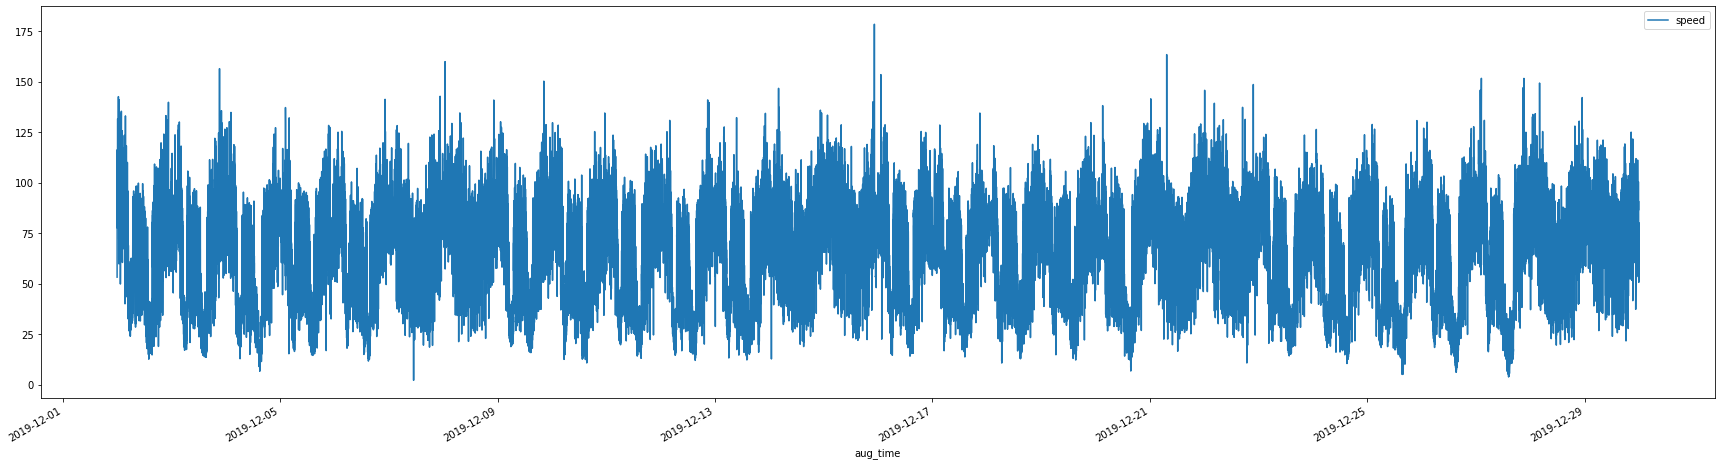

In [5]:
stationary_check  = sm.tsa.stattools.adfuller(aug_data["speed"])
print(f"p value is {stationary_check[1]} ")
aug_data.plot(kind="line" , y="speed", figsize=(30,8));

### Agregation on time bins & NaNs

 number of NaNs 33


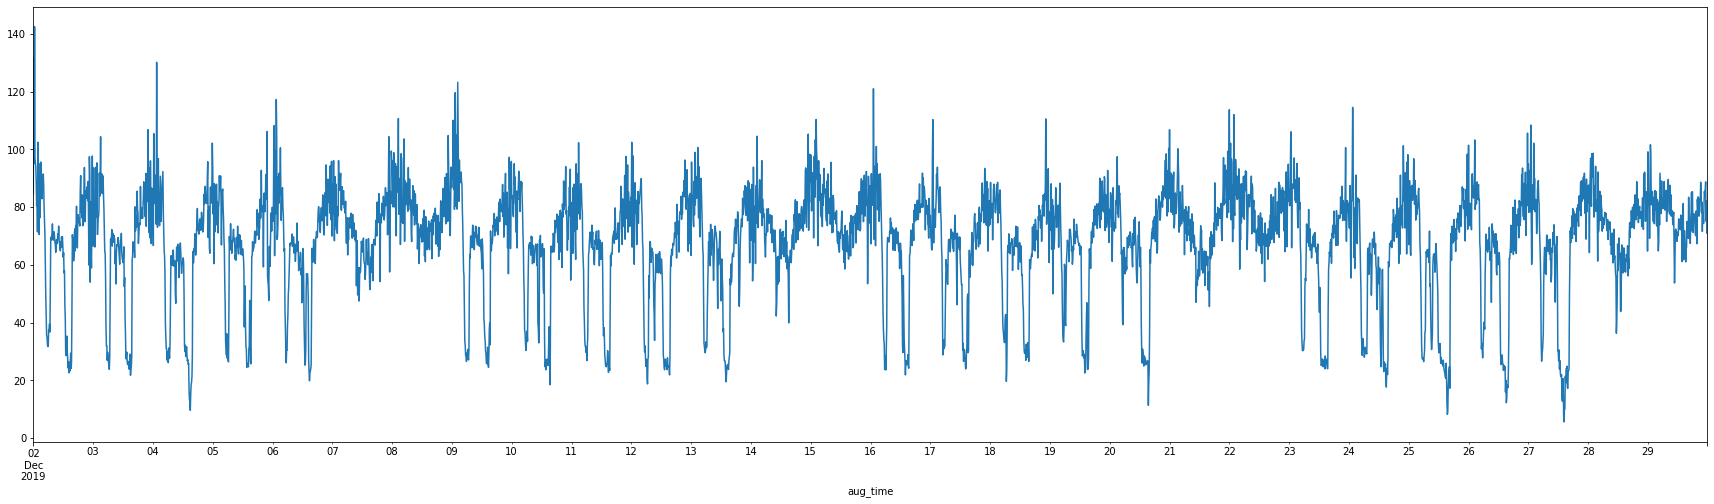

In [6]:
time_bin = "10T"
aux_data = aug_data["speed"].resample(time_bin).mean()

print(f" number of NaNs {aux_data.isna().sum().item()}")

aux_data = aux_data.fillna(method="backfill")
aux_data.plot(kind="line", figsize=(30,8));


In [7]:
print(sm.tsa.stattools.adfuller(aux_data)[1])

1.1947691582919922e-21


In [8]:
time_1 = dt.time.fromisoformat("21:00:00")
time_2 = dt.time.fromisoformat("06:00:00")
aux_data = aux_data.loc[~((aux_data.index.time > time_1) | (aux_data.index.time < time_2))]

In [9]:
aux_data = aux_data.to_frame(name="speed")
aux_data["int_based"] = np.arange(0,len(aux_data))


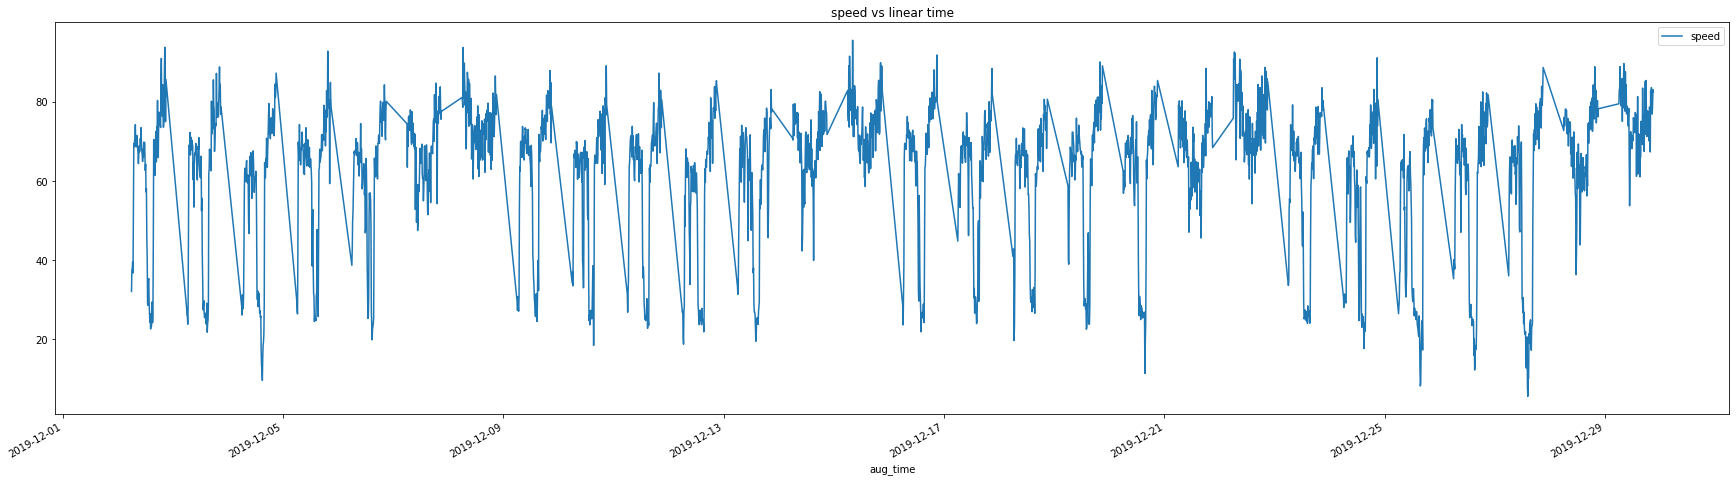

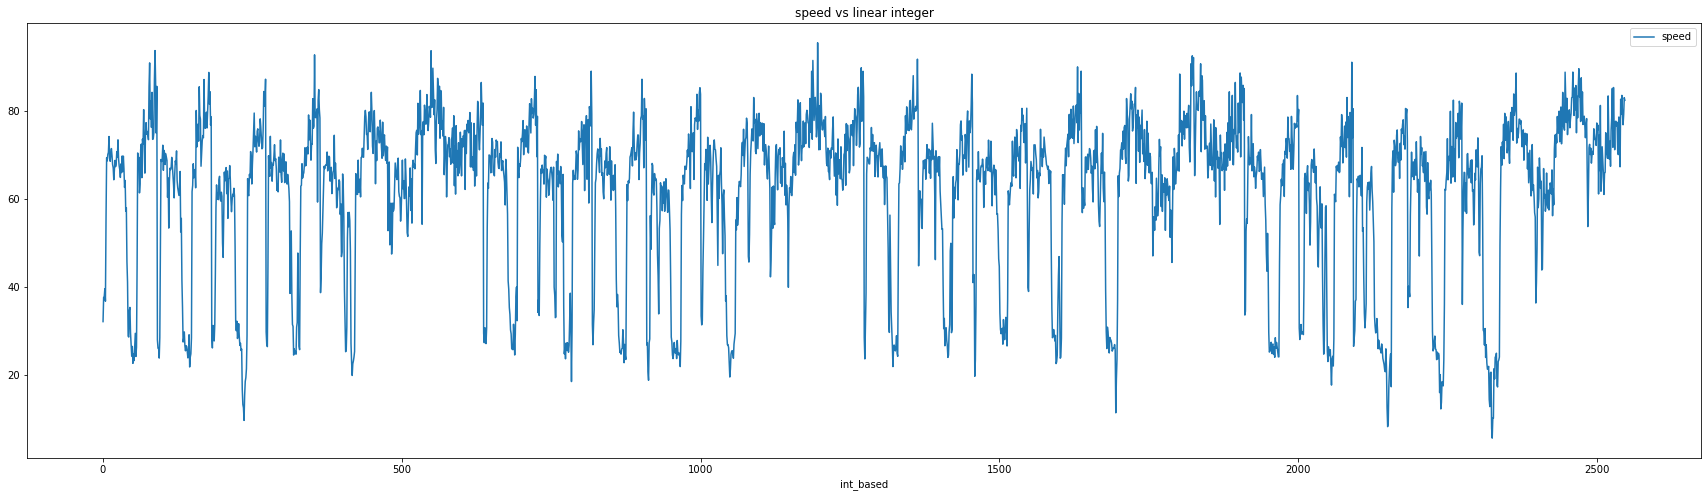

In [10]:
aux_data.plot(kind="line", y="speed", figsize=(30,8), title="speed vs linear time");
aux_data.plot(kind="line",x="int_based", y="speed", figsize=(30,8), title="speed vs linear integer");

In [11]:
print(sm.tsa.stattools.adfuller(aux_data["speed"]))

(-10.550157102975904, 8.215685314666562e-19, 19, 2528, {'1%': -3.432939379929173, '5%': -2.862683979868293, '10%': -2.5673789838429837}, 17641.65914485464)


### Discarding weekend days

<ipython-input-12-db59e64c99c9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux_data["int_based"] = np.arange(0,len(aux_data))


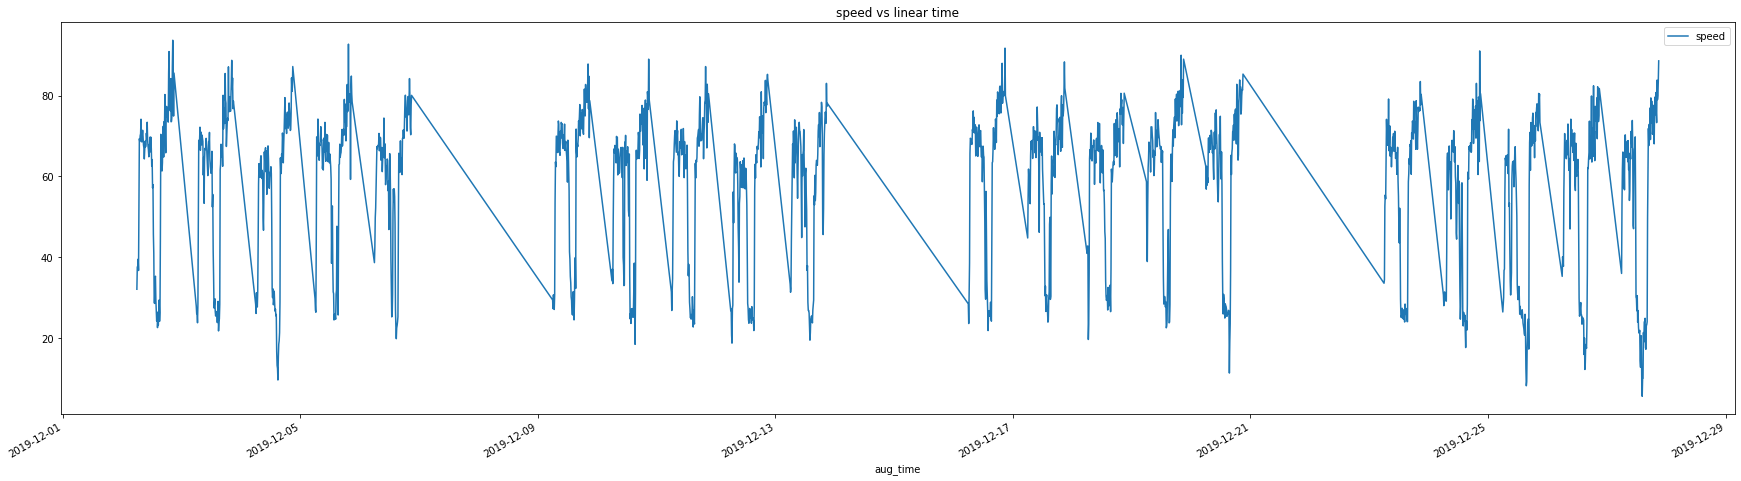

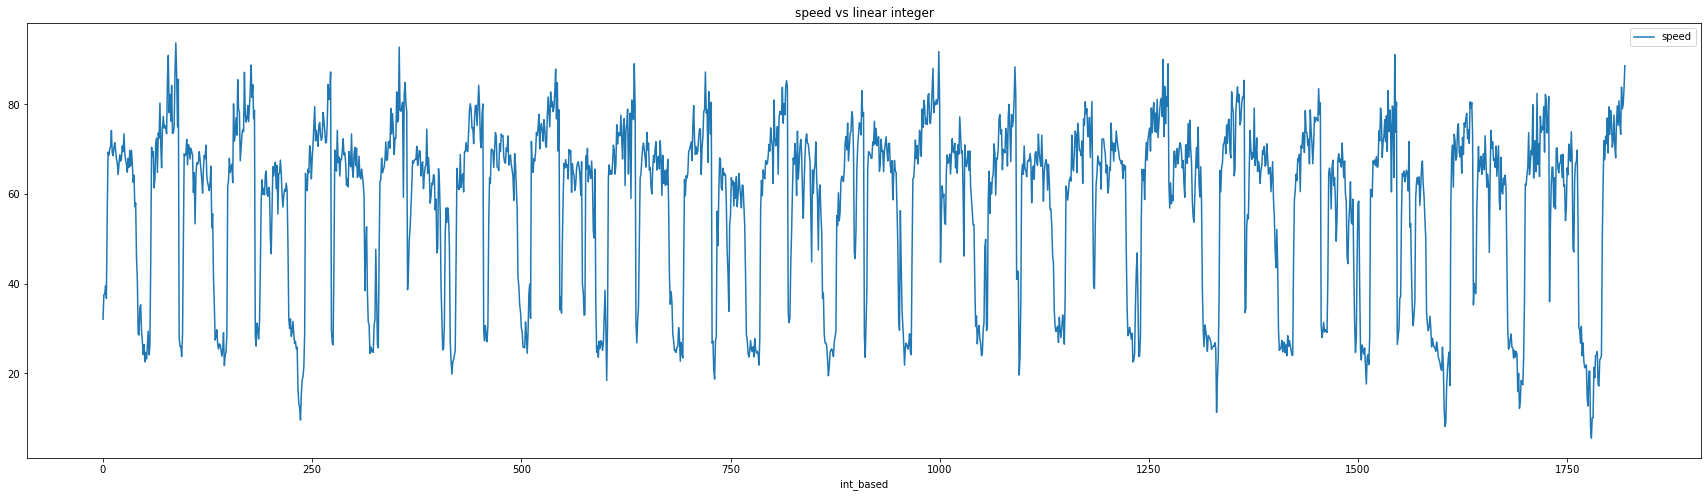

In [12]:
aux_data = aux_data.loc[~((aux_data.index.weekday == 6) | (aux_data.index.weekday == 5))]

aux_data.loc[:,"int_based"] = np.arange(0,len(aux_data))

aux_data.plot(kind="line", y="speed", figsize=(30,8), title="speed vs linear time");
aux_data.plot(kind="line",x="int_based", y="speed", figsize=(30,8), title="speed vs linear integer");

#### bir gün 91 datapoint

In [13]:
print(sm.tsa.stattools.adfuller(aux_data["speed"]))

(-10.590304574613747, 6.554046392955186e-19, 19, 1800, {'1%': -3.4339881389288407, '5%': -2.863147035877915, '10%': -2.567625533641975}, 12718.01708928003)


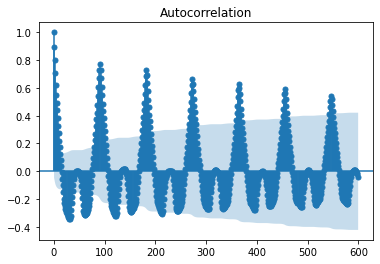

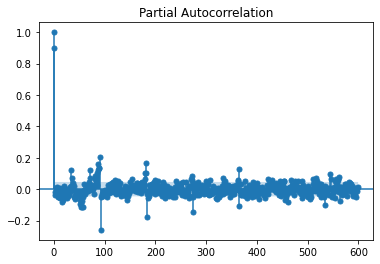

In [14]:
lags=np.arange(0,600,1)
sm.graphics.tsa.plot_acf(aux_data["speed"], lags=lags);
sm.graphics.tsa.plot_pacf(aux_data["speed"], lags=lags);

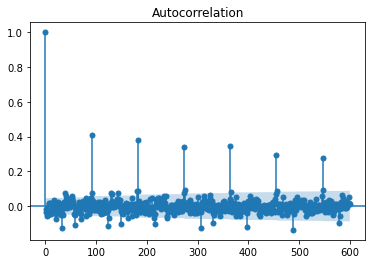

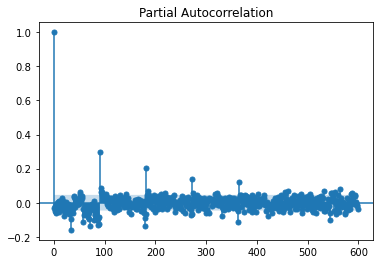

In [15]:
sm.graphics.tsa.plot_acf(aux_data["speed"].diff().dropna(), lags=lags);
sm.graphics.tsa.plot_pacf(aux_data["speed"].diff().dropna(), lags=lags);

In [16]:
def try_arima_coef(series):
    model_results = []

    try:
        p, d,q = 2, 0, 1
        sp, sd, sq = 2, 0, 1
        model = sm.tsa.statespace.SARIMAX(series, order=(p, d, q), seasonal_order=(sp,sd,sq,91))
        results = model.fit()
        model_results.append((p, d, q, results))
    except:
        model_results.append(None)

    # # Loop over p values from 0-2
    # # for seasonal_lag in np.arange(91,93):
    # for p in range(3):
    #     # Loop over q values from 0-2
    #     for d in range(2):
    #         for q in range(3):
    #
    #             try:
    #                 # create and fit ARMA(p,q) model
    #                 model = sm.tsa.statespace.SARIMAX(series, order=(p, d, q), seasonal_order=(p,d,q,400))
    #                 results = model.fit()
    #
    #                 # Print order and results
    #                 # print(p, q, results.aic, results.bic)
    #                 model_results.append((p, d, q, results.aic, results.bic))
    #             except:
    #                 # print
    #                 model_results.append((p, d, q, None, None))
    return model_results

In [17]:
result = try_arima_coef(aux_data["speed"])

C:\Users\k\miniconda3\envs\jlab\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\k\miniconda3\envs\jlab\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\k\miniconda3\envs\jlab\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [18]:
# arima_results = result[2]
arima_results = result[0][3]

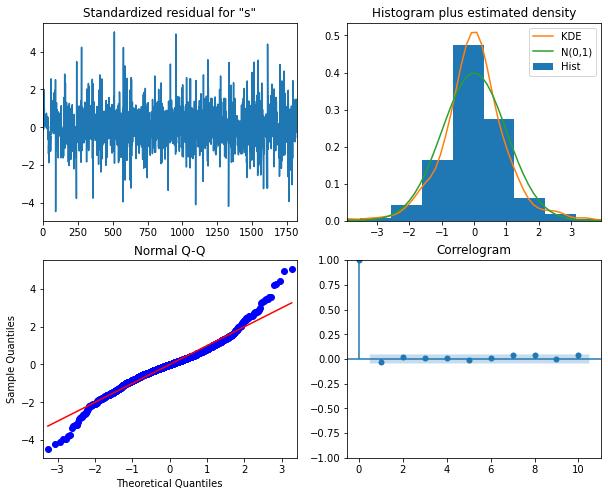

In [19]:
arima_results.plot_diagnostics(figsize=(10,8));
# plt.show()

C:\Users\k\miniconda3\envs\jlab\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


<AxesSubplot:xlabel='int_based'>

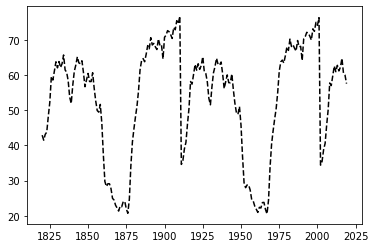

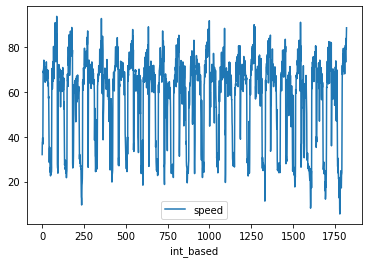

In [20]:
n_forecast = 200
fcast = arima_results.get_forecast(n_forecast).summary_frame(alpha=0.1)
fig, ax = plt.subplots()
fcast['mean'].plot(ax=ax, style='k--')
# fcast.
fig, ax = plt.subplots()
aux_data.plot(ax=ax,kind="line",x="int_based", y="speed")
# fig, ax = plt.subplots()
#
# data2.plot(ax=ax)
# fcast['mean'].plot(ax=ax, style='k--')
# ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1)
# plt.show()

In [21]:
time_index = [aux_data.index[-1] + np.timedelta64(10, "m")*i for i in range(1,n_forecast+1)]
# int_index = np.arange(aux_data.iloc[-1]["int_based"]+1,n_forecast+aux_data.iloc[-1]["int_based"]+1)

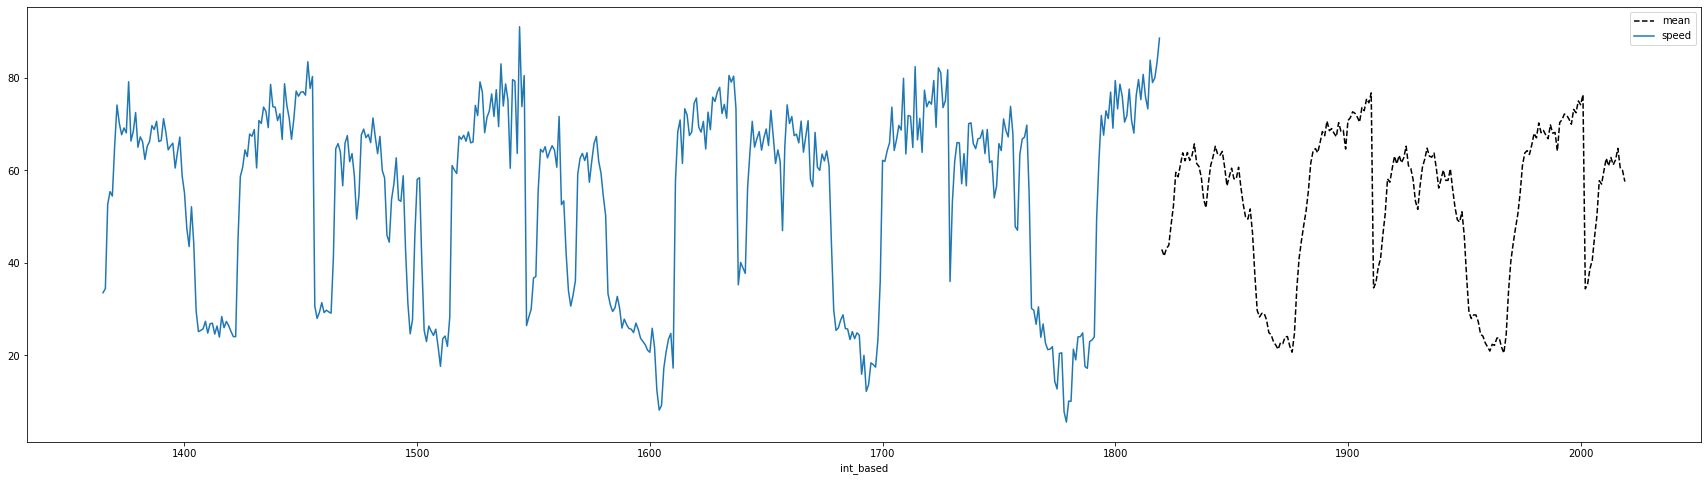

In [22]:
fig, ax = plt.subplots(figsize=(30, 8))

# plt.plot(int_index, fcast['mean'], color="g");

fcast['mean'].plot(ax=ax, style='k--', legend="forecast")

aux_data.iloc[-91*5:].plot(kind="line", x="int_based", y="speed", ax=ax);
# plt.plot(aux_data.iloc[-91*2:]["int_based"], aux_data.iloc[-91*2:]["speed"], ax=ax);

